In [1]:
#from pprint import pprint   # only for this example
import matplotlib.pyplot as plt
from agilent_ir_file import AgilentIRFile
import library_OS_fit as lib_OS
import spec_process as spec_p
import numpy as np
import agilent_to_python as a2p
from scipy import stats
import pandas as pd
from collections import Counter
from calc_pca import cpca

#from skimage import morphology, measure

from skimage.morphology import disk, closing, medial_axis, skeletonize
from skimage.measure import label, regionprops, regionprops_table


c:\Users\Shreyas.Patankar\Anaconda3\envs\py39\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
filename = r'C:\Users\Shreyas.Patankar\Ocean Wise Conservation Association\Plastics Lab Team - General\00_FTIR_Data\mosaic_test_and_results\test20230424b\test20230424b.dmt'
reader = AgilentIRFile()
reader.read(filename)

xvalues = reader.wavenumbers
intensities = reader.intensities
metadata = reader.metadata

print(xvalues)
print(intensities.shape)
#pprint(metadata)
intensities = a2p.hsi_df(reader)
wavenumbers = a2p.data_wns(reader)

[ 898.66574955  900.59421682  902.5226841  ... 3897.43236017 3899.36082745
 3901.28929472]
(1152, 1152, 1558)


In [3]:

im = reader.total_image
mask = im > 5*im.mean()

In [4]:

lbls, ns = label(mask, return_num = True)
props = regionprops(lbls)


In [5]:
library_wavenos = lib_OS.get_lib_wns()

smoothing_order = 2
smoothing_window = 5

clust_der_values = pd.read_csv('OS_clusters_derint.csv')
#clust_der_values = clust_der_values.iloc[:,3:].values.T

def norm_pearson(p,q):
    modp = p/(np.max(p) - np.min(p))
    modq = q/(np.max(q) - np.min(q))
    return stats.pearsonr(modp,modq)[0]


def pearson_rs(p):
    def normp_pearson(q):
        return norm_pearson(p,q)
    return np.apply_along_axis(normp_pearson,axis=0,arr=clust_der_values)

def bPR(p):
    proc = spec_p.proc(p,smoothing_window, smoothing_order,wavenumbers,library_wavenos)
    prsc = pearson_rs(proc)
    ix = np.argmax(prsc)
    if prsc[ix] > 0.3:
        return (ix , prsc[ix])
    else: return (ix, prsc[ix])



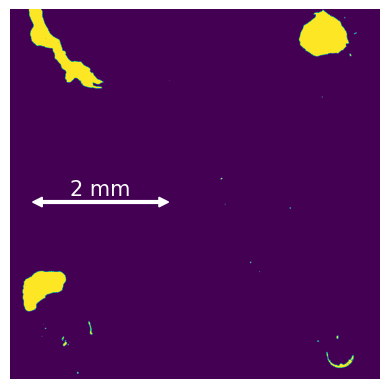

pca calculated
pca calculated
pca calculated
pca calculated
pca calculated
pca calculated
pca calculated
pca calculated
pca calculated
pca calculated
pca calculated
pca calculated
pca calculated
pca calculated
pca calculated
pca calculated
pca calculated
pca calculated


,label,area,solidity,appr_len,appr_wid,polymer,best_pr
0,1,14249.0,0.598044,769.745300,36.694249,polylactic acid,0.238963
1,2,15073.0,0.945134,689.059264,102.042627,polystyrene,0.446018
11,12,10528.0,0.890844,408.012191,66.167206,coal,0.19953
13,14,175.0,0.629496,45.287689,4.426139,cellulose,0.319002
19,20,112.0,0.746667,21.757666,7.096290,polylactic acid,0.247657
23,24,841.0,0.274567,182.984306,7.065647,PTFE,0.28652


In [6]:
# Create figure and axis
fig, ax = plt.subplots()

# Display the image
ax.imshow(mask)

# Define scalebar parameters
scalebar_length_pixels = 181.82*2  # Adjust this based on your image size
scalebar_length_microns = scalebar_length_pixels * .0055

# Draw the scalebar
scalebar_start = (100, 600)  # Adjust the starting position of the scalebar
scalebar_end = (scalebar_start[0] + scalebar_length_pixels, scalebar_start[1])
scalebar_label = f'{scalebar_length_microns:.0f} mm'

# Draw the scalebar line
ax.plot([scalebar_start[0], scalebar_end[0]], [scalebar_start[1], scalebar_end[1]], color='white', linewidth=3)

# Draw arrowheads at the end of the scalebar
ax.arrow(scalebar_start[0], scalebar_start[1], scalebar_length_pixels, 0, head_width=30, head_length=30, fc='white', ec='white')
ax.arrow(scalebar_end[0], scalebar_end[1], -scalebar_length_pixels, 0, head_width=30, head_length=30, fc='white', ec='white')

# Annotate the scalebar label
ax.annotate(scalebar_label, (scalebar_start[0] + scalebar_length_pixels / 2, scalebar_start[1] - 20),
            color='white', ha='center', fontsize=15)

# Remove axes
ax.axis('off')

# Show the image with scalebar
plt.show()

polyids = []
polyprs = []

for prop in props:
    lst = prop.coords
    elements = []

    for coords in lst:
        row_index, column_index = coords
        spectrum = intensities[row_index, column_index]
        elements.append(spectrum)

    if len(elements) > 5:
        pcas = cpca(np.array(elements),range(1))[0]
        polyids.append(lib_OS.catID(bPR(pcas)[0]))
        polyprs.append(bPR(pcas)[1])
    else: 
        polyids.append('small particle')
        polyprs.append('0')


#len(props)
#axs[3].imshow(skeletonize(props[2].image))
#props[3].orientation

def appr_len(region):
    q = np.arctan(np.shape(region)[0]/np.shape(region)[1])
    return (np.sum(skeletonize(region)))*((np.sqrt(2)-1)*(np.sin(2*q)**2)+1)

def appr_wid(region):
    skel, distance = medial_axis(region, return_distance=True)
    return np.mean([2*k for k in distance.flatten() if k >= np.percentile(distance.flatten(),95)])

morph_table = pd.DataFrame(regionprops_table(lbls, properties = ['label','area','axis_major_length', 'axis_minor_length', 'solidity'], extra_properties = (appr_len,appr_wid,)))


morph_table = morph_table[['label','area','solidity','appr_len','appr_wid']]
morph_table['polymer'] = polyids
morph_table['best_pr'] = polyprs

morph_table = morph_table[morph_table['area'] > 100]
morph_table